In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_FilmTrust'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/filmtrust'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'userId', 'itemId', 'rating', 'f_mean_on_self',
       'f_min_on_self', 'f_max_on_self', 'f_sum_on_self', 'f_mean_on_other',
       'f_min_on_other', 'f_max_on_other', 'f_sum_on_other', 'random_dstype',
       'flag_train', 'f_na_mean_on_self', 'f_na_min_on_self',
       'f_na_max_on_self', 'f_na_sum_on_self', 'f_na_mean_on_other',
       'f_na_min_on_other', 'f_na_max_on_other', 'f_na_sum_on_other',
       'user_idx', 'item_idx'],
      dtype='object')

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_')].tolist()

In [6]:
naCols=dftrain.columns[dftrain.columns.str.startswith('f_na')].tolist()

In [7]:
denseCols

['f_mean_on_self',
 'f_min_on_self',
 'f_max_on_self',
 'f_sum_on_self',
 'f_mean_on_other',
 'f_min_on_other',
 'f_max_on_other',
 'f_sum_on_other',
 'f_na_mean_on_self',
 'f_na_min_on_self',
 'f_na_max_on_self',
 'f_na_sum_on_self',
 'f_na_mean_on_other',
 'f_na_min_on_other',
 'f_na_max_on_other',
 'f_na_sum_on_other']

In [8]:
naCols

['f_na_mean_on_self',
 'f_na_min_on_self',
 'f_na_max_on_self',
 'f_na_sum_on_self',
 'f_na_mean_on_other',
 'f_na_min_on_other',
 'f_na_max_on_other',
 'f_na_sum_on_other']

In [9]:
for myNm in naCols:
    dftrain[myNm]=dftrain[myNm].astype(int)
    dfvalid[myNm]=dfvalid[myNm].astype(int)

### Dataset and DataLoader

In [10]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [11]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols],dftrain['rating'],denseCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols],dfvalid['rating'],denseCols)

In [12]:
dftrain.shape

(32036, 24)

In [13]:
bs=32

In [14]:
dltrain=DataLoader(dstrain,bs,True)

In [15]:
dlvalid=DataLoader(dsvalid,bs,False)

## Model Architecture

In [16]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
hidden=[20,25,10]
dropouts=[0.2,0.3,0.2]

In [17]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [18]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
#pretrain_wts=None

In [19]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1,self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:]
        out2=self.lin2(denses)
        
        out3=torch.cat([out1,out2,biased],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [21]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=16, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([32, 18]), torch.Size([32, 1]))

In [24]:
Xb.dtype

torch.float32

In [25]:
cfobj.forward(Xb,Yb)

(tensor([[1.7023],
         [1.8592],
         [1.9074],
         [2.0409],
         [2.0948],
         [1.8521],
         [2.2297],
         [1.4732],
         [1.7521],
         [1.6226],
         [2.0068],
         [2.0028],
         [1.9633],
         [2.0345],
         [2.0660],
         [2.3288],
         [2.2415],
         [2.0959],
         [2.3179],
         [0.6793],
         [2.3101],
         [1.7396],
         [2.0729],
         [2.1837],
         [2.5788],
         [2.2846],
         [2.0302],
         [2.2691],
         [2.0288],
         [2.3718],
         [1.8211],
         [0.9334]], grad_fn=<AddBackward0>),
 tensor(2.1146, grad_fn=<MseLossBackward>))

## Learner

In [26]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [50]:
device='cuda:1'

In [51]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [52]:
cfobj=cfobj.to(device)

In [53]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=16, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [54]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [55]:
len(dltrain)

1002

In [56]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

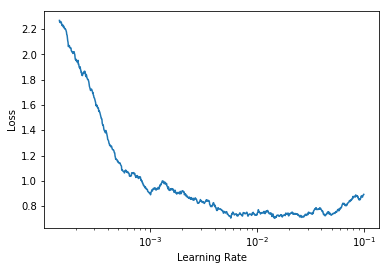

In [57]:
learner.plot_lrs(50)

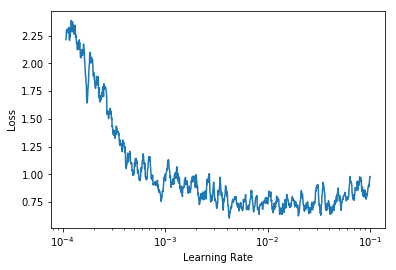

In [58]:
learner.plot_lrs(10)

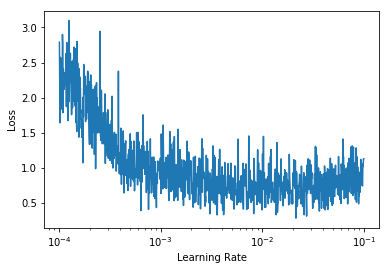

In [59]:
learner.plot_lrs(1)

In [60]:
del cfobj
torch.cuda.empty_cache()

In [61]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [62]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [63]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [64]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-2,end_lr=3e-3,wd_mult=1.15)

In [65]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 0.0001 Train Loss:0.6590914987102002                 Valid Loss:0.6620544793955777 Train RMSE:0.8025242647484107 Valid RMSE:0.8032931436958667 Train MSE:0.6590914987102002 Valid MSE:0.6620544793955777                 Train MAE:0.6337748090188184 Valid MAE:0.6423624248132793
Epoch:1 Learning rate 0.0038729833462074173 Weight Decay 0.00011499999999999999 Train Loss:0.5709197006361213                 Valid Loss:0.6851956792380831 Train RMSE:0.7476521144037214 Valid RMSE:0.8161013359439289 Train MSE:0.5709197006361213 Valid MSE:0.6851956792380831                 Train MAE:0.5860924572942262 Valid MAE:0.6538804824199151
Epoch:2 Learning rate 0.0030000000000000005 Weight Decay 0.00013225 Train Loss:0.550321301597797                 Valid Loss:0.6787710290983182 Train RMSE:0.734248482131795 Valid RMSE:0.8135395299645896 Train MSE:0.550321301597797 Valid MSE:0.6787710290983182                 Train MAE:0.5739216520460304 Valid MAE:0.6514450426495403
Epo

In [66]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [67]:
if 1==1:
    optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-2,end_lr=2e-3,wd_mult=1.15)
    learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.005 Weight Decay 0.0001 Train Loss:0.6523686007014708                 Valid Loss:0.6507871044338296 Train RMSE:0.7995348314152391 Valid RMSE:0.7964615099118355 Train MSE:0.6523686007014708 Valid MSE:0.6507871044338296                 Train MAE:0.6311339652407431 Valid MAE:0.6287908950530061
Epoch:1 Learning rate 0.0031622776601683794 Weight Decay 0.00011499999999999999 Train Loss:0.5811989016072479                 Valid Loss:0.6540677274039032 Train RMSE:0.7540961979705719 Valid RMSE:0.7985928890551884 Train MSE:0.5811989016072479 Valid MSE:0.6540677274039032                 Train MAE:0.5879879602772033 Valid MAE:0.6413244063701105
Epoch:2 Learning rate 0.002 Weight Decay 0.00013225 Train Loss:0.526399693267788                 Valid Loss:0.64609705226137 Train RMSE:0.717717574950191 Valid RMSE:0.7924775624119622 Train MSE:0.526399693267788 Valid MSE:0.64609705226137                 Train MAE:0.5568426241596302 Valid MAE:0.6255071461200714


In [68]:
learner.generate_scores=True

In [69]:
learner.run_epoch(dlvalid,False)

(0.64609705226137, 0.6255071461200714, 0.7924775624119622)

In [70]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [71]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8054141766372722

In [72]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [73]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.614213,0.783718,0.606508,0.246636,No-cold-start
1,dnnrec,0.946289,0.972774,0.800842,0.061161,User-Cold-Start
2,dnnrec,0.912123,0.955051,0.738495,0.022330,Item-Cold_start
3,dnnrec,1.296026,1.138431,0.989598,-0.117264,User-Item-cold-start
0,dnnrec,0.614213,0.783718,0.606508,0.246636,0
1,dnnrec,0.955838,0.977670,0.798951,0.065918,1
0,dnnrec,0.648692,0.805414,0.625930,0.224558,0


In [74]:
results_concat.shape

(77, 6)

In [75]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [76]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))

In [77]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.638513,0.799070,0.622871,0.216831,No-cold-start
1,biasedmatrixfactorization,0.925556,0.962058,0.771413,0.081731,User-Cold-Start
2,biasedmatrixfactorization,1.016274,1.008104,0.775404,-0.089305,Item-Cold_start
3,biasedmatrixfactorization,1.649868,1.284472,1.099969,-0.422300,User-Item-cold-start
0,biasedmatrixfactorization,0.638513,0.799070,0.622871,0.216831,0
1,biasedmatrixfactorization,0.971243,0.985517,0.786175,0.050864,1
0,biasedmatrixfactorization,0.672094,0.819813,0.639352,0.196583,0
0,svdplusplus,0.648519,0.805307,0.643882,0.204558,No-cold-start
1,svdplusplus,0.939454,0.969254,0.780966,0.067942,User-Cold-Start
2,svdplusplus,0.964594,0.982138,0.773659,-0.033912,Item-Cold_start


In [4]:
import pickle
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load (open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','rb'))
results_concat.to_csv(f'{PATH}/filmtrust_results.csv',index=False)

In [7]:
PATH

'/home/kirana/Documents/phd/experiment1_new/DNNREC_FilmTrust'